In [39]:
import glob
from joblib import dump, load
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import warnings
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

## Gust processing

### Create a dataframe for gust with all campgrounds and the corresponding coordinates and nearest grid cells

In [2]:
# Define the locations and their coordinates
locations = {
    "Bern": (2595842.15, 1201548.69),
    "Brienz": (2646563.43, 1177603.88),
    "Buochs": (2674514.65, 1203568.08),
    "Interlaken": (2632995.62, 1171399.67),
    "Lugano": (2713926.15, 1094747.56),
    "Salavaux": (2569175.20, 1195846.24),
    "Sempach": (2657011.60, 1219718.50),
    "Gordevio": (2700590.96, 1119701.60),
    "Thun": (2614554.68, 1178201.33),
    "Morges": (2527116.10, 1150785.39)
}

# Open your datasets
path = '/scratch2/cwenger/ICON-CH1_monthly/ICON-CH1_gust_data/ICON-CH1-EPS_2024-08-12T12_agg.nc'
ds = xr.open_dataset(path)  # Replace with your actual dataset

# Loop through each location to find the nearest x and y and save variables
for name, (loc_x, loc_y) in locations.items():
    # Find the nearest grid cell
    nearest_x = ds.sel(x=loc_x, y=loc_y, method="nearest").x.values
    nearest_y = ds.sel(x=loc_x, y=loc_y, method="nearest").y.values

    # Save variables dynamically
    globals()[f"{name}_cell_x"] = nearest_x
    globals()[f"{name}_cell_y"] = nearest_y


locations_df = pd.DataFrame([(name, coord[0], coord[1]) for name, coord in locations.items()], columns=['name', 'x_coordinate', 'y_coordinate'])
# Add x_cell and y_cell columns to the dataframe
locations_df['x_cell_nearest'] = locations_df['name'].apply(lambda name: globals().get(f"{name}_cell_x"))
locations_df['y_cell_nearest'] = locations_df['name'].apply(lambda name: globals().get(f"{name}_cell_y"))
dump(locations_df, 'campgrounds_coordinates_gust.pkl')

['campgrounds_coordinates_gust.pkl']

### Load campground dataframe and select subset of dataset that only considers the chosen campground for gust

In [3]:
campgrounds_gust = load('campgrounds_coordinates_gust.pkl')

In [4]:
# Open your gust dataset
icon_path_gust = '/scratch2/cwenger/ICON-CH1_monthly/ICON-CH1_gust_data/ICON-CH1-EPS_2024-08-12T12_agg.nc'
ds_icon_gust = xr.open_dataset(icon_path_gust)

### Choose camping site for gust plot

In [6]:
# CHOOSE CAMPING SITE
c_name = 'Brienz'


# Define the window size (in grid points)
full_window = 35
half_window = int((full_window-1)/2)

center_x = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['x_cell_nearest'].values[0]
center_y = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['y_cell_nearest'].values[0]

# Get the indices of the nearest grid point
x_index = int(ds_icon_gust.x.to_index().get_loc(center_x))
y_index = int(ds_icon_gust.y.to_index().get_loc(center_y))

# Compute index bounds
x_start_idx = max(x_index - half_window, 0)
x_end_idx = min(x_index + half_window + 1, ds_icon_gust.sizes['x'])
y_start_idx = max(y_index - half_window, 0)
y_end_idx = min(y_index + half_window + 1, ds_icon_gust.sizes['y'])

# Extract the window for gust data
window_icon_gust = ds_icon_gust.isel(x=slice(x_start_idx, x_end_idx), y=slice(y_start_idx, y_end_idx))

#### window_icon now contains only the gust data for the chosen campground with a 35kmx35km window around it

### Set the date and the leadtime as variables

In [7]:
selected_date = '2024081212'
selected_leadtime = 0

### Plot gust wind speed for the specific campground and the window around the campground

In [ ]:
warnings.filterwarnings("ignore")

# plot the actual data, for a specific date, time step, and member
for member_number in range(11): # Loop through members 0 to 10
    data_wind = window_icon_gust.sel(lead_time=selected_leadtime, realization=member_number).wind_speed_of_gust.squeeze()

    # Define the Swiss coordinate system (EPSG:2056)
    swiss_proj = ccrs.epsg(2056)

    # Compute the extent of the data
    min_x, max_x = data_wind.x.values.min(), data_wind.x.values.max()
    min_y, max_y = data_wind.y.values.min(), data_wind.y.values.max()
    extent_x = max_x - min_x
    extent_y = max_y - min_y

    # Dynamically adjust figure size to maintain a square aspect ratio
    fig_size = 13  # Base figure size
    aspect_ratio = extent_y / extent_x
    fig_width = fig_size
    fig_height = fig_size * aspect_ratio if aspect_ratio >= 1 else fig_size
    fig_width = fig_size / aspect_ratio if aspect_ratio < 1 else fig_size

    # Create the figure and axes
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = plt.axes(projection=swiss_proj)
    ax.set_aspect('1')  # Ensure square aspect ratio for the map

    # Set the extent of the map
    ax.set_extent([min_x, max_x, min_y, max_y], crs=swiss_proj)


    # Add the WMS layer for Switzerland's topography
    wms_url = 'https://wms.geo.admin.ch/?'
    layer = 'ch.swisstopo.pixelkarte-grau'
    ax.add_wms(wms_url, layer)

    # Add the WMS layer for Switzerland's borders
    border_layer = 'ch.swisstopo.swissboundaries3d-land-flaeche.fill'
    ax.add_wms(wms_url, layers=border_layer)
    canton_layer = 'ch.swisstopo.swissboundaries3d-kanton-flaeche.fill'  # Cantonal borders


    # Define colormap and normalization
    colors = [
    "#F9EEC3",  # 18–21
    "#E3CF7A",  # 21–24
    "#B7A34B",  # 24–27
    "#7A763A",  # 27–30
    "#444B2B",  # >30
    ]
    cmap = mcolors.ListedColormap(colors)
    bounds = [18, 21, 24, 27, 30]
    norm = mcolors.BoundaryNorm(bounds, cmap.N - 1)


    # Plot the data
    im = ax.contourf(
        data_wind.x,
        data_wind.y,
        data_wind,
        levels=bounds,
        transform=swiss_proj,
        cmap=cmap, norm=norm,
        alpha=0.8, extend='max'
    )

    # add blue contour line for threshold_1
    threshold_line_1 = 18

    cs = ax.contour(
        data_wind.x,
        data_wind.y,
        data_wind,
        levels=[threshold_line_1],
        colors='#1E90FF',
        linewidths=4.0,
        transform=swiss_proj,
        linestyles='-'
    )

    # add red contour line for threshold_2
    threshold_line_2 = 25

    cs = ax.contour(
        data_wind.x,
        data_wind.y,
        data_wind,
        levels=[threshold_line_2],
        colors='#D62828',
        linewidths=4.0,
        transform=swiss_proj,
        linestyles='-'
    )

        # Add legend
    legend_lines = [
        Line2D([0], [0], color="#1E90FF", lw=3.0),
        Line2D([0], [0], color="#D62828", lw=3.0),
    ]
    legend_labels = [f'{threshold_line_1} m s⁻¹', f'{threshold_line_2} m s⁻¹']
    legend = ax.legend(
        handles=legend_lines,
        labels=legend_labels,
        loc='upper left',
        bbox_to_anchor=(-0.366, 1.0),
        fontsize=20,
        framealpha=0.9,
        title='Warning Threshold',
        title_fontsize=20
    )
    legend._legend_box.align = "left"


    # Add the colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=30, shrink=0.825)
    cbar.set_label('Wind Gust [m s⁻¹]', fontsize=20)
    cbar.set_ticks(bounds)
    cbar.ax.yaxis.set_major_locator(mticker.FixedLocator(bounds))
    cbar.set_ticklabels([str(b) for b in bounds])
    cbar.ax.tick_params(labelsize=20)

    # Add dot where camping site is located
    # Plot campsite location as a prominent dot on top of all layers
    x_dot = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['x_cell_nearest'].values[0]
    y_dot = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['y_cell_nearest'].values[0]
    ax.scatter(
        x_dot, y_dot,
        transform=swiss_proj,
        s=250,              
        c='#FF2E2E',      
        edgecolors='k',       
        linewidths=1.5,
        zorder=1000
    )

    # Extract date, time, and member values
    date_val = str(selected_date)
    time_val = int(data_wind.coords['lead_time'].values)
    member_val = int(data_wind.coords['realization'].values)
    c_name_lower = c_name[0].lower() + c_name[1:]


    # Save figure
    directory_to_save = f'/scratch2/cwenger/ICON-CH1_monthly/figures_{c_name_lower}'
    plt.savefig(f'{directory_to_save}/{date_val}_{c_name_lower}_gust_time{time_val}_member{member_val}.png', dpi=150, bbox_inches='tight')
    


## Precipitation processing

### Create a dataframe for precipitaton with all campgrounds and the corresponding coordinates and nearest grid cells

In [9]:
# Define the locations and their coordinates
locations = {
    "Bern": (2595842.15, 1201548.69),
    "Brienz": (2646563.43, 1177603.88),
    "Buochs": (2674514.65, 1203568.08),
    "Interlaken": (2632995.62, 1171399.67),
    "Lugano": (2713926.15, 1094747.56),
    "Salavaux": (2569175.20, 1195846.24),
    "Sempach": (2657011.60, 1219718.50),
    "Gordevio": (2700590.96, 1119701.60),
    "Thun": (2614554.68, 1178201.33),
    "Morges": (2527116.10, 1150785.39)
}

# Open your datasets
path = '/scratch2/cwenger/ICON-CH1_monthly/ICON-CH1_08_2024_agg.nc'
ds = xr.open_dataset(path)  # Replace with your actual dataset

# Loop through each location to find the nearest x and y and save variables
for name, (loc_x, loc_y) in locations.items():
    # Find the nearest grid cell
    nearest_x = ds.sel(x=loc_x, y=loc_y, method="nearest").x.values
    nearest_y = ds.sel(x=loc_x, y=loc_y, method="nearest").y.values

    # Save variables dynamically
    globals()[f"{name}_cell_x"] = nearest_x
    globals()[f"{name}_cell_y"] = nearest_y


locations_df = pd.DataFrame([(name, coord[0], coord[1]) for name, coord in locations.items()], columns=['name', 'x_coordinate', 'y_coordinate'])
# Add x_cell and y_cell columns to the dataframe
locations_df['x_cell_nearest'] = locations_df['name'].apply(lambda name: globals().get(f"{name}_cell_x"))
locations_df['y_cell_nearest'] = locations_df['name'].apply(lambda name: globals().get(f"{name}_cell_y"))
dump(locations_df, 'campgrounds_coordinates_precip.pkl')

['campgrounds_coordinates_precip.pkl']

### Load campground dataframe and select subset of dataset that only considers the chosen campground for precipitation

In [11]:
campgrounds_precip = load('campgrounds_coordinates_precip.pkl')

In [12]:
# Open your precipitation dataset
icon_path_precip = '/scratch2/cwenger/ICON-CH1_monthly/ICON-CH1_08_2024_agg.nc'
ds_icon_precip = xr.open_dataset(icon_path_precip)

### Choose camping site for precipitation plot

In [13]:
# CHOOSE CAMPING SITE
c_name = 'Brienz'


# Define the window size (in grid points)
full_window = 35
half_window = int((full_window-1)/2)

center_x = campgrounds_precip[campgrounds_precip['name'].str.contains(c_name)]['x_cell_nearest'].values[0]
center_y = campgrounds_precip[campgrounds_precip['name'].str.contains(c_name)]['y_cell_nearest'].values[0]

# Get the indices of the nearest grid point
x_index = int(ds_icon_precip.x.to_index().get_loc(center_x))
y_index = int(ds_icon_precip.y.to_index().get_loc(center_y))

# Compute index bounds
x_start_idx = max(x_index - half_window, 0)
x_end_idx = min(x_index + half_window + 1, ds_icon_precip.sizes['x'])
y_start_idx = max(y_index - half_window, 0)
y_end_idx = min(y_index + half_window + 1, ds_icon_precip.sizes['y'])

# Extract the window for precipitation data
window_icon_precip = ds_icon_precip.isel(x=slice(x_start_idx, x_end_idx), y=slice(y_start_idx, y_end_idx))

#### window_icon now contains only the precipitation data for the chosen campground with a 35kmx35km window around it

### Plot the precipitation for the specific campground and the window around the campground

In [ ]:
warnings.filterwarnings("ignore")

# Plot the actual data, for a specific date, time step, and member
for member_number in range(11): # Loop through members 0 to 10
    data_prec = window_icon_precip.sel(date=selected_date, time=selected_leadtime, members=member_number).tot_prec_1h

    # Define the Swiss coordinate system (EPSG:2056)
    swiss_proj = ccrs.epsg(2056)

    # Compute the extent of the data
    min_x, max_x = data_prec.x.values.min(), data_prec.x.values.max()
    min_y, max_y = data_prec.y.values.min(), data_prec.y.values.max()
    extent_x = max_x - min_x
    extent_y = max_y - min_y

    # Dynamically adjust figure size to maintain a square aspect ratio
    fig_size = 13  # Base figure size
    aspect_ratio = extent_y / extent_x
    fig_width = fig_size
    fig_height = fig_size * aspect_ratio if aspect_ratio >= 1 else fig_size
    fig_width = fig_size / aspect_ratio if aspect_ratio < 1 else fig_size

    # Create the figure and axes
    fig = plt.figure(figsize=(fig_width, fig_height))
    ax = plt.axes(projection=swiss_proj)
    ax.set_aspect('1')  # Ensure square aspect ratio for the map

    # Set the extent of the map
    ax.set_extent([min_x, max_x, min_y, max_y], crs=swiss_proj)


    # Add the WMS layer for Switzerland's topography
    wms_url = 'https://wms.geo.admin.ch/?'
    layer = 'ch.swisstopo.pixelkarte-grau'
    ax.add_wms(wms_url, layer)

    # Add the WMS layer for Switzerland's borders
    border_layer = 'ch.swisstopo.swissboundaries3d-land-flaeche.fill'
    ax.add_wms(wms_url, layers=border_layer)
    canton_layer = 'ch.swisstopo.swissboundaries3d-kanton-flaeche.fill'  # Cantonal borders


    # Define colormap and normalization
    colors = ['#0f79b1', '#06488e', '#1f0d64', '#6a2c5a']
    cmap = mcolors.ListedColormap(colors)
    bounds = [10, 20, 40, 60]
    norm = mcolors.BoundaryNorm(bounds, cmap.N - 1)


    # Plot the data
    im = ax.contourf(
        data_prec.x,
        data_prec.y,
        data_prec,
        levels=bounds,
        transform=swiss_proj,
        cmap=cmap, norm=norm,
        alpha=0.8, extend='max'
    )

    # add yellow contour line for threshold_1
    threshold_line_1 = 13.6

    cs = ax.contour(
        data_prec.x,
        data_prec.y,
        data_prec,
        levels=[threshold_line_1],
        colors='#FFD700',
        linewidths=4.0,
        transform=swiss_proj,
        linestyles='-'
    )

    # add red contour line for threshold_2
    threshold_line_2 = 32.2

    cs = ax.contour(
        data_prec.x,
        data_prec.y,
        data_prec,
        levels=[threshold_line_2],
        colors='#D62828',
        linewidths=4.0,
        transform=swiss_proj,
        linestyles='-'
    )
    
       # Add legend
    legend_lines = [
        Line2D([0], [0], color="#FFD700", lw=3.0),
        Line2D([0], [0], color="#D62828", lw=3.0),
    ]
    legend_labels = [f'{threshold_line_1} m s⁻¹', f'{threshold_line_2} m s⁻¹']
    legend = ax.legend(
        handles=legend_lines,
        labels=legend_labels,
        loc='upper left',
        bbox_to_anchor=(-0.366, 1.0),
        fontsize=20,
        framealpha=0.9,
        title='Warning Threshold',
        title_fontsize=20
    )
    legend._legend_box.align = "left"

    # Add the colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, aspect=30,shrink=0.825)
    cbar.set_label('Precipitation [mm h⁻¹]', fontsize=20)
    cbar.ax.tick_params(labelsize=20)

    # Add dot where camping site is located
    # Plot campsite location as a prominent dot on top of all layers
    x_dot = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['x_cell_nearest'].values[0]
    y_dot = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['y_cell_nearest'].values[0]
    ax.scatter(
        x_dot, y_dot,
        transform=swiss_proj,
        s=250,              
        c='#FF2E2E',      
        edgecolors='k',       
        linewidths=1.5,
        zorder=1000
    )
    
    # Extract date, time, and member values
    date_val = str(data_prec.coords['date'].values)
    time_val = int(data_prec.coords['time'].values)
    member_val = int(data_prec.coords['members'].values)
    c_name_lower = c_name[0].lower() + c_name[1:]

    # Save figure
    directory_to_save = f'/scratch2/cwenger/ICON-CH1_monthly/figures_{c_name_lower}'
    plt.savefig(f'{directory_to_save}/{date_val}_{c_name_lower}_precipitation_time{time_val}_member{member_val}.png', dpi=150, bbox_inches='tight')



### Wind gust contours plotted for members exceeding threshold level

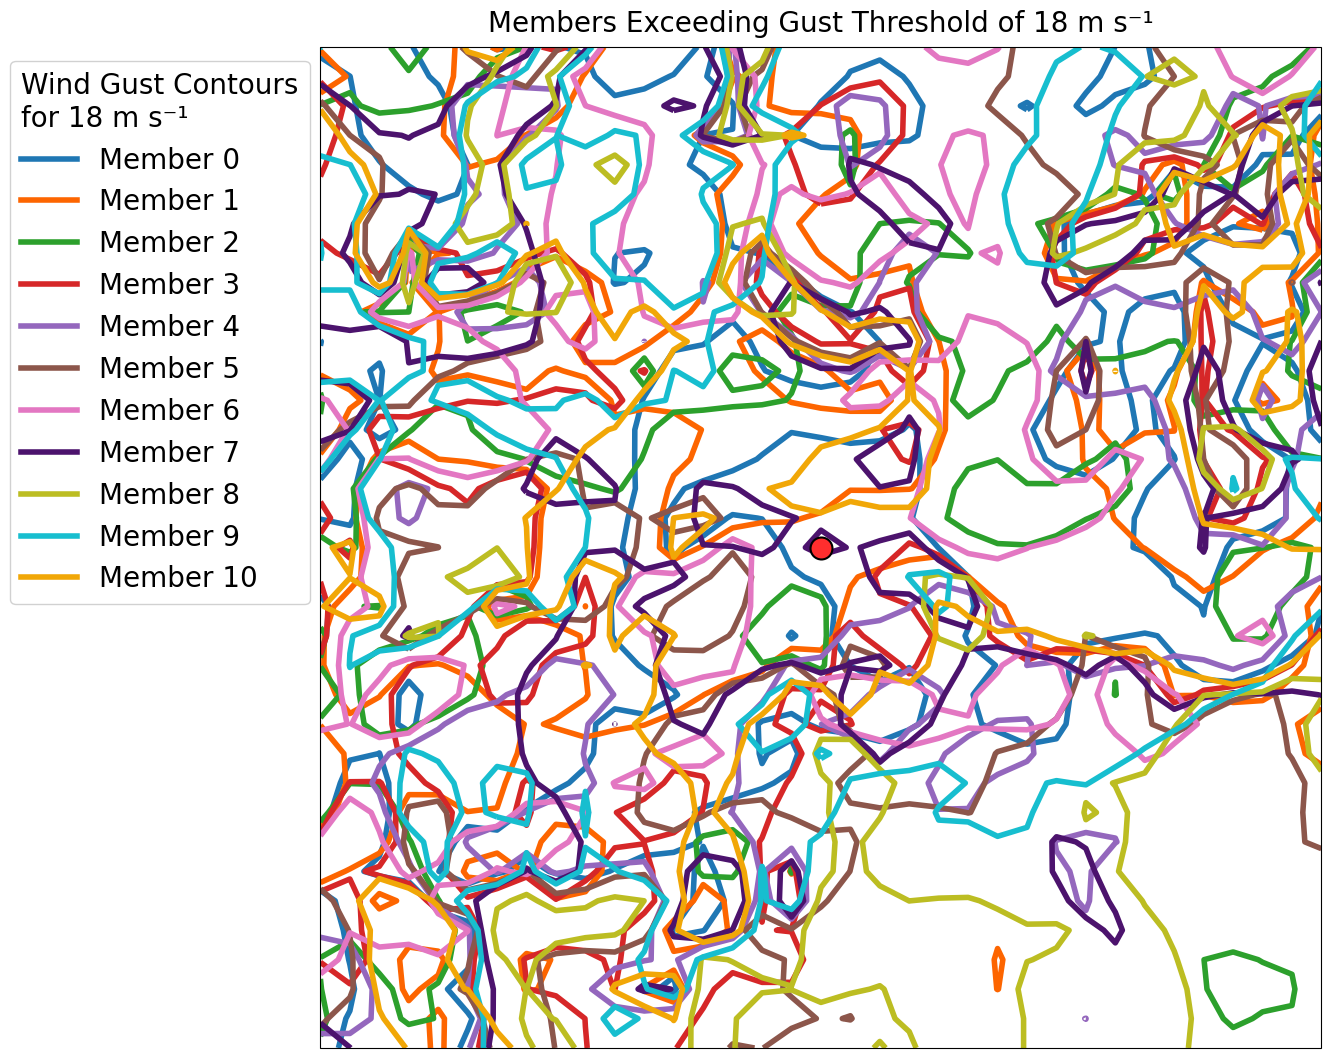

In [ ]:
warnings.filterwarnings("ignore")

data_wind = window_icon_gust.sel(lead_time=selected_leadtime, realization=member_number).wind_speed_of_gust.squeeze()

# Define the Swiss coordinate system (EPSG:2056)
swiss_proj = ccrs.epsg(2056)

# Compute the extent of the data
min_x, max_x = data_wind.x.values.min(), data_wind.x.values.max()
min_y, max_y = data_wind.y.values.min(), data_wind.y.values.max()
extent_x = max_x - min_x
extent_y = max_y - min_y

# Dynamically adjust figure size to maintain a square aspect ratio
fig_size = 13  # Base figure size
aspect_ratio = extent_y / extent_x
fig_width = fig_size
fig_height = fig_size * aspect_ratio if aspect_ratio >= 1 else fig_size
fig_width = fig_size / aspect_ratio if aspect_ratio < 1 else fig_size

# Create the figure and axes
fig = plt.figure(figsize=(fig_width, fig_height))
ax = plt.axes(projection=swiss_proj)
ax.set_aspect('1')  # Ensure square aspect ratio for the map

# Set the extent of the map
ax.set_extent([min_x, max_x, min_y, max_y], crs=swiss_proj)


# Add the WMS layer for Switzerland's topography
""""
wms_url = 'https://wms.geo.admin.ch/?'
layer = 'ch.swisstopo.pixelkarte-grau'
ax.add_wms(wms_url, layer)
"""

# Add the WMS layer for Switzerland's borders
border_layer = 'ch.swisstopo.swissboundaries3d-land-flaeche.fill'
ax.add_wms(wms_url, layers=border_layer)
canton_layer = 'ch.swisstopo.swissboundaries3d-kanton-flaeche.fill'  # Cantonal borders

# Define colormap and normalization
colors = [
    "#1f77b4", "#fd6500", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#4c136d",
    "#bcbd22", "#17becf", "#f1a707"
]
cmap = mcolors.ListedColormap(colors)

threshold = 18

# Plot the threshold contour for members exceeding the gust threshold
legend_lines, legend_labels = [], []

for member_number in range(11):
    data_wind = window_icon_gust.sel(
        lead_time=selected_leadtime,
        realization=member_number
    ).wind_speed_of_gust.squeeze()

    cs = ax.contour(
        data_wind.x, data_wind.y, data_wind,
        levels=[threshold],
        colors=[colors[member_number]],
        linewidths=4.0,
        linestyles="-",
        transform=swiss_proj
    )
    legend_lines.append(Line2D([0], [0], color=colors[member_number], lw=4.0))
    legend_labels.append(f"Member {member_number}")

# Add legend
legend = ax.legend(
    handles=legend_lines,
    labels=legend_labels,
    loc="upper left",
    bbox_to_anchor=(-0.324, 1.0),
    fontsize=20,
    framealpha=0.9,
    title=f'Wind Gust Contours\nfor {threshold} m s⁻¹',
    title_fontsize=20
)
legend._legend_box.align = "left"

# Title
ax.set_title(f'Members Exceeding Gust Threshold of {threshold} m s⁻¹', fontsize=20, pad=11)

# Add dot where camping site is located
# Plot campsite location as a prominent dot on top of all layers
x_dot = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['x_cell_nearest'].values[0]
y_dot = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['y_cell_nearest'].values[0]
ax.scatter(
    x_dot, y_dot,
    transform=swiss_proj,
    s=250,              
    c='#FF2E2E',      
    edgecolors='k',       
    linewidths=1.5,
    zorder=1000
)

# Extract date, time, and member values
date_val = str(selected_date)
time_val = int(data_wind.coords['lead_time'].values)
c_name_lower = c_name[0].lower() + c_name[1:]

# Save figure
directory_to_save = f"/scratch2/cwenger/ICON-CH1_monthly/figures_{c_name_lower}"
plt.savefig(f"{directory_to_save}/{date_val}_{c_name_lower}_gust_members_exceeding_threshold{threshold}_time{time_val}.png",
            dpi=150, bbox_inches="tight")


### Precipitation contours plotted for members exceeding threshold level

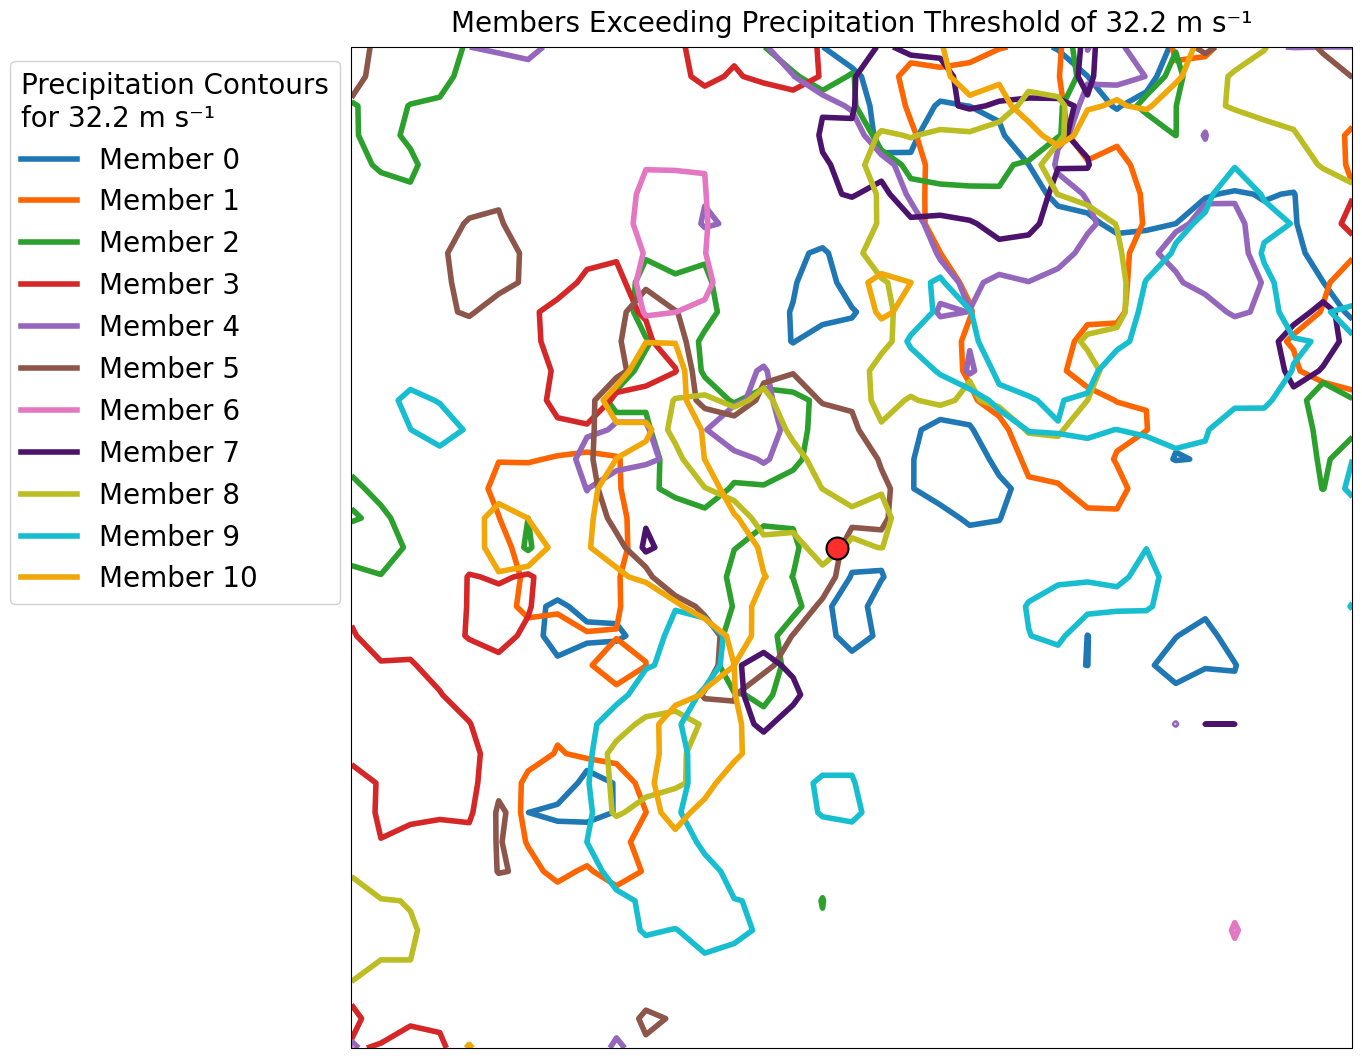

In [53]:
warnings.filterwarnings("ignore")

data_precip = window_icon_precip.sel(time=selected_leadtime, members=member_number).tot_prec_1h.squeeze()

# Define the Swiss coordinate system (EPSG:2056)
swiss_proj = ccrs.epsg(2056)

# Compute the extent of the data
min_x, max_x = data_precip.x.values.min(), data_precip.x.values.max()
min_y, max_y = data_precip.y.values.min(), data_precip.y.values.max()
extent_x = max_x - min_x
extent_y = max_y - min_y

# Dynamically adjust figure size to maintain a square aspect ratio
fig_size = 13  # Base figure size
aspect_ratio = extent_y / extent_x
fig_width = fig_size
fig_height = fig_size * aspect_ratio if aspect_ratio >= 1 else fig_size
fig_width = fig_size / aspect_ratio if aspect_ratio < 1 else fig_size

# Create the figure and axes
fig = plt.figure(figsize=(fig_width, fig_height))
ax = plt.axes(projection=swiss_proj)
ax.set_aspect('1')  # Ensure square aspect ratio for the map

# Set the extent of the map
ax.set_extent([min_x, max_x, min_y, max_y], crs=swiss_proj)


# Add the WMS layer for Switzerland's topography
""""
wms_url = 'https://wms.geo.admin.ch/?'
layer = 'ch.swisstopo.pixelkarte-grau'
ax.add_wms(wms_url, layer)
"""

# Add the WMS layer for Switzerland's borders
border_layer = 'ch.swisstopo.swissboundaries3d-land-flaeche.fill'
ax.add_wms(wms_url, layers=border_layer)
canton_layer = 'ch.swisstopo.swissboundaries3d-kanton-flaeche.fill'  # Cantonal borders

# Define colormap and normalization
colors = [
    "#1f77b4", "#fd6500", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#4c136d",
    "#bcbd22", "#17becf", "#f1a707"
]
cmap = mcolors.ListedColormap(colors)

threshold = 32.2

# Plot the threshold contour for members exceeding the gust threshold
legend_lines, legend_labels = [], []

for member_number in range(11):
    # select the specific date as well so the resulting DataArray is 2D (y, x)
    data_precip = window_icon_precip.sel(
        date=selected_date,
        time=selected_leadtime,
        members=member_number
    ).tot_prec_1h.squeeze()

    cs = ax.contour(
        data_precip.x, data_precip.y, data_precip,
        levels=[threshold],
        colors=[colors[member_number]],
        linewidths=4.0,
        linestyles="-",
        transform=swiss_proj
    )
    legend_lines.append(Line2D([0], [0], color=colors[member_number], lw=4.0))
    legend_labels.append(f"Member {member_number}")

# Add legend
legend = ax.legend(
    handles=legend_lines,
    labels=legend_labels,
    loc="upper left",
    bbox_to_anchor=(-0.355, 1.0),
    fontsize=20,
    framealpha=0.9,
    title=f'Precipitation Contours\nfor {threshold} m s⁻¹',
    title_fontsize=20
)
legend._legend_box.align = "left"

# Title
ax.set_title(f'Members Exceeding Precipitation Threshold of {threshold} m s⁻¹', fontsize=20, pad=11)

# Add dot where camping site is located
# Plot campsite location as a prominent dot on top of all layers
x_dot = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['x_cell_nearest'].values[0]
y_dot = campgrounds_gust[campgrounds_gust['name'].str.contains(c_name)]['y_cell_nearest'].values[0]
ax.scatter(
    x_dot, y_dot,
    transform=swiss_proj,
    s=250,              
    c='#FF2E2E',      
    edgecolors='k',       
    linewidths=1.5,
    zorder=1000
)

# Extract date, time, and member values
date_val = str(selected_date)
time_val = int(data_precip.coords['time'].values)
c_name_lower = c_name[0].lower() + c_name[1:]

# Save figure
directory_to_save = f"/scratch2/cwenger/ICON-CH1_monthly/figures_{c_name_lower}"
plt.savefig(f"{directory_to_save}/{date_val}_{c_name_lower}_precipitation_members_exceeding_threshold{threshold}_time{time_val}.png",
            dpi=150, bbox_inches="tight")


### Print statistics for a selected date, leadtime, and member

In [ ]:
print(f"\n--- Some statistics for {c_name} at {selected_date}, leadtime {selected_leadtime} ---")

# Define thresholds for wind damage
threshold_1 = 18
threshold_2 = 25

# Save the area numbers for each member
area_thresholds_1, area_thresholds_2 = [], []

# Over one specific member
for member in range(11):
    print(f"\n---  Member {member} ---")
    wind_gust = window_icon_gust.sel(lead_time=selected_leadtime, realization=member).wind_speed_of_gust
    precipitation = window_icon_precip.sel(date=selected_date, time=selected_leadtime, members=member).tot_prec_1h
    max_wind_gust_member = wind_gust.max().values
    min_wind_gust_member = wind_gust.min().values
    mean_wind_gust_member = wind_gust.mean().values
    max_precipitation_member = precipitation.max().values
    min_precipitation_member = precipitation.min().values
    mean_precipitation_member = precipitation.mean().values

    # Save the area numbers for each member
    area_thresholds_1, area_thresholds_2 = [], []

    data_wind = window_icon_gust.sel(
        lead_time=selected_leadtime,
        realization=member_number
    ).wind_speed_of_gust.squeeze()

    exceed_count_1 = int(((data_wind > threshold_1).sum(dim=["y", "x"])).item())

    data_wind = window_icon_gust.sel(
        lead_time=selected_leadtime,
        realization=member_number
    ).wind_speed_of_gust.squeeze()

    exceed_count_2 = int(((data_wind > threshold_2).sum(dim=["y", "x"])).item())

    print("Max. wind gust:", max_wind_gust_member, "m s⁻¹")
    print("Min. wind gust:", min_wind_gust_member, "m s⁻¹")
    print("Mean wind gust:", mean_wind_gust_member, "m s⁻¹")
    print()
    print("Max. precipitation:", max_precipitation_member, "mm h⁻¹")
    print("Min. precipitation:", min_precipitation_member, "mm h⁻¹")
    print("Mean precipitation:", mean_precipitation_member, "mm h⁻¹")
    print()
    print(f"Area exceeding wind threshold of {threshold_1} m s⁻¹:", exceed_count_1, "km² of 1225 km² (", round(exceed_count_1 / 1225 * 100), "% )")
    print(f"Area exceeding wind threshold of {threshold_2} m s⁻¹:", exceed_count_2, "km² of 1225 km² (", round(exceed_count_2 / 1225 * 100), "% )")

# Save the area numbers for each member
area_thresholds_1, area_thresholds_2 = [], []
print(f"\n--- Areas exceeding wind threshold of {threshold_1} m s⁻¹ (per member) ---")
for member_number in range(11):
    data_wind = window_icon_gust.sel(
        lead_time=selected_leadtime,
        realization=member_number
    ).wind_speed_of_gust.squeeze()

    exceed_count_1 = int(((data_wind > threshold_1).sum(dim=["y", "x"])).item())
    area_thresholds_1.append(exceed_count_1)
    
    print(f"Member {member_number}: {exceed_count_1} km² of 1225 km² ({round(exceed_count_1 / 1225 * 100)}%)")
print()
print(f"--- Areas exceeding wind threshold of {threshold_2} m s⁻¹ (per member) ---")
for member_number in range(11):
    data_wind = window_icon_gust.sel(
        lead_time=selected_leadtime,
        realization=member_number
    ).wind_speed_of_gust.squeeze()
    
    exceed_count_2 = int(((data_wind > threshold_2).sum(dim=["y", "x"])).item())
    area_thresholds_2.append(exceed_count_2)

    print(f"Member {member_number}: {exceed_count_2} km² of 1225 km² ({round(exceed_count_2 / 1225 * 100)}%)")

# Over all members
max_wind_gust = []
min_wind_gust = []
mean_wind_gust = []
max_precipitation = []
min_precipitation = []
mean_precipitation = []
mean_area_threshold_1 = []
mean_area_threshold_2 = []

for member in range(11):
    wind = window_icon_gust.sel(lead_time=selected_leadtime, realization=member).wind_speed_of_gust
    precipitation = window_icon_precip.sel(date=selected_date, time=selected_leadtime, members=member).tot_prec_1h
    max_wind_gust.append(wind.max().values)
    min_wind_gust.append(wind.min().values)
    mean_wind_gust.append(wind.mean().values)
    max_precipitation.append(precipitation.max().values)
    min_precipitation.append(precipitation.min().values)
    mean_precipitation.append(precipitation.mean().values)
    mean_area_threshold_1.append(np.mean(area_thresholds_1))
    mean_area_threshold_2.append(np.mean(area_thresholds_2))

print("\n--- Over all 11 members ---")
print("Max. wind gust:", np.max(max_wind_gust), "m s⁻¹")
print("Min. wind gust:", np.min(min_wind_gust), "m s⁻¹")
print("Mean wind gust:", np.mean(mean_wind_gust), "m s⁻¹")
print()
print("Max. precipitation:", np.max(max_precipitation), "mm h⁻¹")
print("Min. precipitation:", np.min(min_precipitation), "mm h⁻¹")
print("Mean precipitation:", np.mean(mean_precipitation), "mm h⁻¹")
print()
print(f"Mean area exceeding wind threshold of {threshold_1} m s⁻¹: {round(np.mean(mean_area_threshold_1))} km² of 1225 km² ({round(np.mean(mean_area_threshold_1) / 1225 * 100)}%)")
print(f"Mean area exceeding wind threshold of {threshold_2} m s⁻¹: {round(np.mean(mean_area_threshold_2))} km² of 1225 km² ({round(np.mean(mean_area_threshold_2) / 1225 * 100)}%)")

# Save statistics to a text file
c_name_lower = c_name[0].lower() + c_name[1:]
directory_to_save = f'/scratch2/cwenger/ICON-CH1_monthly/figures_{c_name_lower}'
with open(f'{directory_to_save}/{selected_date}_{c_name_lower}_gust_precipitation_statistics_time{selected_leadtime}.txt', 'w') as f:
    f.write(f"\n--- Some statistics for {c_name} at {selected_date}, leadtime {selected_leadtime} ---\n")
    for member in range(11):
        wind_gust = window_icon_gust.sel(lead_time=selected_leadtime, realization=member).wind_speed_of_gust
        precipitation = window_icon_precip.sel(date=selected_date, time=selected_leadtime, members=member).tot_prec_1h
        max_wind_gust_member = wind_gust.max().values
        min_wind_gust_member = wind_gust.min().values
        mean_wind_gust_member = wind_gust.mean().values
        max_precipitation_member = precipitation.max().values
        min_precipitation_member = precipitation.min().values
        mean_precipitation_member = precipitation.mean().values

        f.write(f"\n--- Member {member} ---\n")
        f.write(f"Max. wind gust: {max_wind_gust_member} m s⁻¹\n")
        f.write(f"Min. wind gust: {min_wind_gust_member} m s⁻¹\n")
        f.write(f"Mean wind gust: {mean_wind_gust_member} m s⁻¹\n")
        f.write(f"\n")
        f.write(f"Max. precipitation: {max_precipitation_member} mm h⁻¹\n")
        f.write(f"Min. precipitation: {min_precipitation_member} mm h⁻¹\n")
        f.write(f"Mean precipitation: {mean_precipitation_member} mm h⁻¹\n")
        f.write(f"\n")
        f.write(f"Area exceeding wind threshold of {threshold_1} m s⁻¹: {exceed_count_1} km² of 1225 km² ({round(exceed_count_1 / 1225 * 100)}%)\n")
        f.write(f"Area exceeding wind threshold of {threshold_2} m s⁻¹: {exceed_count_2} km² of 1225 km² ({round(exceed_count_2 / 1225 * 100)}%)\n")

    # Save the area numbers for each member
    area_thresholds_1, area_thresholds_2 = [], []

    f.write(f"\n--- Areas exceeding wind threshold of {threshold_1} m s⁻¹ (per member) ---\n")
    for member_number in range(11):
        data_wind = window_icon_gust.sel(
            lead_time=selected_leadtime,
            realization=member_number
        ).wind_speed_of_gust.squeeze()

        exceed_count_1 = int(((data_wind > threshold_1).sum(dim=["y", "x"])).item())
        area_thresholds_1.append(exceed_count_1)

        f.write(f"Member {member_number}: {exceed_count_1} km² of 1225 km² ({round(exceed_count_1 / 1225 * 100)}%)\n")
    f.write(f"\n--- Areas exceeding wind threshold of {threshold_2} m s⁻¹ (per member) ---\n")
    for member_number in range(11):
        data_wind = window_icon_gust.sel(
            lead_time=selected_leadtime,
            realization=member_number
        ).wind_speed_of_gust.squeeze()

        exceed_count_2 = int(((data_wind > threshold_2).sum(dim=["y", "x"])).item())
        area_thresholds_2.append(exceed_count_2)

        f.write(f"Member {member_number}: {exceed_count_2} km² of 1225 km² ({round(exceed_count_2 / 1225 * 100)}%)\n")


    f.write(f"\n--- Over all 11 members ---\n")
    f.write(f"Max. wind gust: {np.max(max_wind_gust)} m s⁻¹\n")
    f.write(f"Min. wind gust: {np.min(min_wind_gust)} m s⁻¹\n")
    f.write(f"Mean wind gust: {np.mean(mean_wind_gust)} m s⁻¹\n")
    f.write(f"\n")
    f.write(f"Max. precipitation: {np.max(max_precipitation)} mm h⁻¹\n")
    f.write(f"Min. precipitation: {np.min(min_precipitation)} mm h⁻¹\n")
    f.write(f"Mean precipitation: {np.mean(mean_precipitation)} mm h⁻¹\n")
    f.write(f"\n")
    f.write(f"Mean area exceeding wind threshold of {threshold_1} m s⁻¹: {round(np.mean(mean_area_threshold_1))} km² of 1225 km² ({round(np.mean(mean_area_threshold_1) / 1225 * 100)}%)\n")
    f.write(f"Mean area exceeding wind threshold of {threshold_2} m s⁻¹: {round(np.mean(mean_area_threshold_2))} km² of 1225 km² ({round(np.mean(mean_area_threshold_2) / 1225 * 100)}%)\n")


### Place the wind contours over the precipitation plot for the specific campground and the window around the campground

### Wind contours plotted over precipitation only for above 18 m s⁻¹ wind speed

### Create a scatterplot for a first visualization of possible correlations between wind and precipitation

### Print out the important statistical numbers